In [15]:
import math

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms

import jax.numpy as jnp
from jax import ops, random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive

az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

Replicate sim


In [16]:
def make_df(rho=-0.7):
    a = 3.5  # average morning wait time
    b = -1  # average difference afternoon wait time
    sigma_a = 1  # std dev in intercepts
    sigma_b = 0.5  # std dev in slopes
    # rho = -0.7  # correlation between intercepts and slopes

    Mu = jnp.array([a, b])
    cov_ab = sigma_a * sigma_b * rho
    Sigma = jnp.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])

    jnp.array([1, 2, 3, 4]).reshape(2, 2).T
    sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
    Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

    # now matrix multiply to get covariance matrix
    Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

    N_cafes = 20
    seed = random.PRNGKey(5)  # used to replicate example
    vary_effects = dist.MultivariateNormal(Mu, Sigma).sample(seed, (N_cafes,))

    a_cafe = vary_effects[:, 0]
    b_cafe = vary_effects[:, 1]

    #---

    seed = random.PRNGKey(22)
    N_visits = 10
    afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
    cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
    mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
    sigma = 0.5  # std dev within cafes
    wait = dist.Normal(mu, sigma).sample(seed)
    return pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

d_rho0 = make_df(0)
d = make_df()

In [17]:
def model(cafe, afternoon, wait):
    a = numpyro.sample("a", dist.Normal(5, 2))
    b = numpyro.sample("b", dist.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = numpyro.deterministic("cov", jnp.outer(sigma_cafe, sigma_cafe) * Rho)
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe_b_cafe", dist.MultivariateNormal(jnp.stack([a, b]), cov).expand([20])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)

m14_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m14_1.run(random.PRNGKey(0), d_rho0.cafe.values, d_rho0.afternoon.values, d_rho0.wait.values)

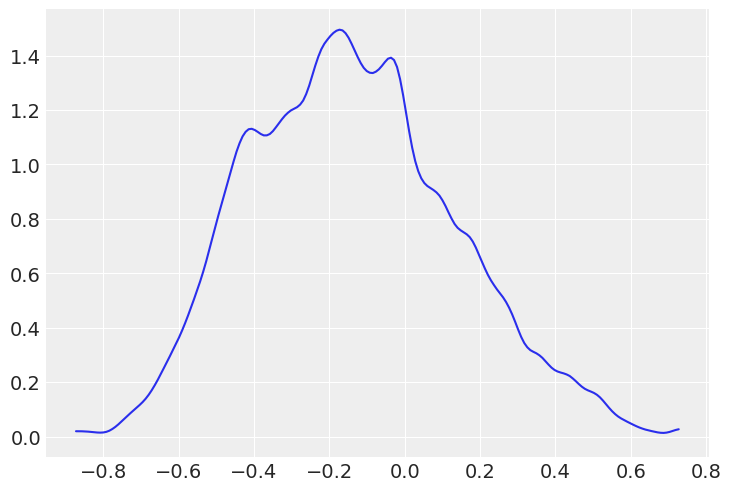

In [18]:
post = m14_1.get_samples()
az.plot_kde(post["Rho"][:, 0, 1], bw=2)
plt.show()

---

In [19]:
m14_2a = MCMC(NUTS(model), 500, 500, num_chains=4)
m14_2a.run(random.PRNGKey(0), d.cafe.values, d.afternoon.values, d.wait.values)

In [20]:
def model(cafe, afternoon, wait):
    n_cafes = len(set(cafe))

    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    sigma_a = numpyro.sample("sigma_a", dist.HalfCauchy(2))
    sigma_b = numpyro.sample("sigma_b", dist.HalfCauchy(2))
    a_cafe = numpyro.sample("a_cafe", dist.Normal(a, sigma_a), sample_shape=(n_cafes,))
    b_cafe = numpyro.sample("b_cafe", dist.Normal(b, sigma_b), sample_shape=(n_cafes,))

    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))
    numpyro.sample("wait", dist.Normal(mu, sigma), obs=wait)

m14_2b = MCMC(NUTS(model), 500, 500, num_chains=4)
m14_2b.run(random.PRNGKey(1), d.cafe.values, d.afternoon.values, d.wait.values)

In [21]:
az.compare(
    {
        "m14_2a": az.from_numpyro(m14_2a),
        "m14_2b": az.from_numpyro(m14_2b),
    },
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m14_2a,0,345.797,30.0422,0,0.862297,19.7968,0,True,deviance
m14_2b,1,351.425,31.2329,5.62877,0.137703,19.8693,3.91894,True,deviance


In [22]:
post_2a = m14_2a.get_samples()
post_2b = m14_2b.get_samples()

print(post_2a["a_cafe_b_cafe"].shape)
print(post_2b["a_cafe"].shape)

a_cafe_2a = jnp.mean(post_2a['a_cafe_b_cafe'], 0)[:,0]
b_cafe_2a = jnp.mean(post_2a['a_cafe_b_cafe'], 0)[:,1]
a_cafe_2b = jnp.mean(post_2b['a_cafe'], 0)
b_cafe_2b = jnp.mean(post_2b['b_cafe'], 0)

(2000, 20, 2)
(2000, 20)


In [23]:
rho_2a = post_2a["Rho"]
sigma_cafe_2a = post_2a["sigma_cafe"]
cov_2a = sigma_cafe_2a[:,:,None] * sigma_cafe_2a[:,None,:] * rho_2a

print(rho_2a[:2])
print(sigma_cafe_2a.shape)
print(post_2a["cov"].shape)
print(cov_2a.shape)

assert jnp.array_equal(post_2a["cov"], cov_2a)

[[[ 1.         -0.7068429 ]
  [-0.7068429   1.        ]]

 [[ 1.         -0.88095075]
  [-0.88095075  1.        ]]]
(2000, 2)
(2000, 2, 2)
(2000, 2, 2)


In [35]:
a_mean_2a = jnp.mean(post_2a['a'], 0)
b_mean_2a = jnp.mean(post_2a['b'], 0)
print(a_mean_2a, b_mean_2a)

rho_est = jnp.mean(post_2a['Rho'][:,0,1], 0)
sa_est = jnp.mean(post_2a["sigma_cafe"][:,0], 0)
sb_est = jnp.mean(post_2a["sigma_cafe"][:,1], 0)
cov_ab = sa_est * sb_est * rho_est
rho_est, sa_est, sb_est, cov_ab
Sigma_est = jnp.array([[sa_est**2, cov_ab], [cov_ab, sb_est**2]])
Sigma_est

3.1239834 -0.86642677


DeviceArray([[ 1.0173562 , -0.3557315 ],
             [-0.3557315 ,  0.24778825]], dtype=float32)

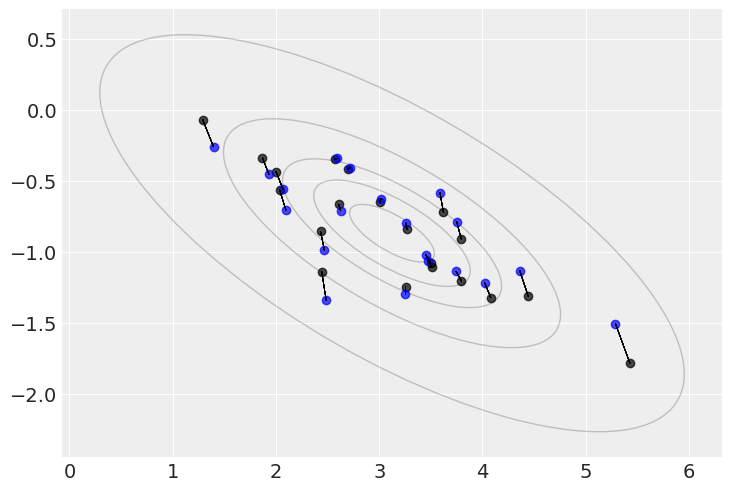

In [36]:
plt.plot(a_cafe_2a, b_cafe_2a, "o", color='k', alpha=0.7)
plt.plot(a_cafe_2b, b_cafe_2b, "o", color='b', alpha=0.7)
for i in range(len(a_cafe_2a)):
    plt.plot([a_cafe_2a, a_cafe_2b], [b_cafe_2a, b_cafe_2b], "k", lw=0.5)

# overlay population distribution
# Ref: https://matplotlib.org/gallery/statistics/confidence_ellipse.html
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma_est[0, 1] / jnp.sqrt(Sigma_est[0, 0] * Sigma_est[1, 1])
    ellipse = Ellipse(
        (0, 0),
        jnp.sqrt(1 + pearson),
        jnp.sqrt(1 - pearson),
        edgecolor="k",
        alpha=0.2,
        facecolor="none",
    )
    std_dev = dist.Normal().icdf((1 + jnp.sqrt(l)) / 2)
    scale_x = 2 * std_dev * jnp.sqrt(Sigma_est[0, 0])
    scale_y = 2 * std_dev * jnp.sqrt(Sigma_est[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(a_mean_2a, b_mean_2a) + plt.gca().transData)
    plt.gca().add_patch(ellipse)

---

In [38]:
ucbadmit = pd.read_csv('../data/UCBadmit.csv', sep=';')
d = ucbadmit
d.columns = [c.replace('.', '_') for c in d.columns]
d["male"] = d.applicant_gender.map({"male": 1, "female": 0})
d["dept_id"] = pd.factorize(d.dept)[0]
d["acc_rate"] = d.admit / d.applications
d.head()

,dept,applicant_gender,admit,reject,applications,male,dept_id,acc_rate
1,A,male,512,313,825,1,0,0.620606
2,A,female,89,19,108,0,0,0.824074
3,B,male,353,207,560,1,1,0.630357
4,B,female,17,8,25,0,1,0.680000
5,C,male,120,205,325,1,2,0.369231


In [149]:
def model(admit, applications, dept_id, male):
    n_depts = len(set(dept_id))

    a = numpyro.sample("a", dist.Normal(0, 10))
    bm = numpyro.sample("bm", dist.Normal(0, 10))

    sigma_dept = numpyro.sample("sigma_dept", dist.HalfCauchy(2).expand([2]))
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))
    cov = jnp.outer(sigma_dept, sigma_dept) * Rho
    
    a_dept_bm_dept = numpyro.sample(
        "a_dept_bm_dept", dist.MultivariateNormal(
            jnp.stack([a, bm]), cov
        ).expand([n_depts])
    )
    a_dept = numpyro.deterministic("a_dept", a_dept_bm_dept[:, 0])
    bm_dept = numpyro.deterministic("bm_dept", a_dept_bm_dept[:, 1])
    
    logit_p = a_dept[dept_id] + bm_dept[dept_id] * male
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)

m14_3a = MCMC(NUTS(model), 500, 500, num_chains=4)
m14_3a.run(random.PRNGKey(3),
    d.admit.values, d.applications.values, d.dept_id.values, d.male.values
)
m14_3a.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
           Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           Rho[0,1]     -0.31      0.36     -0.35     -0.91      0.20   1293.46      1.00
           Rho[1,0]     -0.31      0.36     -0.35     -0.91      0.20   1293.46      1.00
           Rho[1,1]      1.00      0.00      1.00      1.00      1.00   2152.54      1.00
                  a     -0.48      0.69     -0.47     -1.62      0.61   1321.30      1.00
a_dept_bm_dept[0,0]      1.31      0.24      1.31      0.92      1.72    965.65      1.00
a_dept_bm_dept[0,1]     -0.80      0.25     -0.80     -1.23     -0.39    953.44      1.01
a_dept_bm_dept[1,0]      0.75      0.34      0.74      0.21      1.31   1152.69      1.00
a_dept_bm_dept[1,1]     -0.22      0.34     -0.22     -0.74      0.36   1093.39      1.00
a_dept_bm_dept[2,0]     -0.65      0.08     -0.65     -0.79     -0.52   1518.39      1.00
a_dept_bm

In [169]:
def model(admit, applications, dept_id, male):
    n_depts = len(set(dept_id))

    sigma_dept = numpyro.sample("sigma_dept", dist.HalfCauchy(2).expand([2]))
    L_Rho_dept = numpyro.sample("L_Rho_dept", dist.LKJCholesky(2, 2))

    z_dept = numpyro.sample("z_dept", dist.Normal(0, 1).expand([2, n_depts]))
    a_dept_bm_dept = ((sigma_dept[..., None] * L_Rho_dept) @ z_dept).T
    a_dept = numpyro.deterministic("a_dept", a_dept_bm_dept[:, 0])
    bm_dept = numpyro.deterministic("bm_dept", a_dept_bm_dept[:, 1])
    
    logit_p = a_dept[dept_id] + bm_dept[dept_id] * male
    numpyro.sample("admit", dist.Binomial(applications, logits=logit_p), obs=admit)

m14_3b = MCMC(NUTS(model), 500, 500, num_chains=4)
m14_3b.run(random.PRNGKey(234),
    d.admit.values, d.applications.values, d.dept_id.values, d.male.values
)
m14_3b.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
L_Rho_dept[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Rho_dept[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_dept[1,0]     -0.19      0.35     -0.22     -0.72      0.41   1130.56      1.00
L_Rho_dept[1,1]      0.91      0.11      0.95      0.76      1.00   1024.21      1.00
  sigma_dept[0]      1.71      0.61      1.58      0.79      2.49    404.55      1.00
  sigma_dept[1]      0.48      0.25      0.43      0.13      0.81    565.10      1.00
    z_dept[0,0]      0.80      0.30      0.76      0.34      1.23    520.93      1.00
    z_dept[0,1]      0.41      0.24      0.38      0.06      0.78    585.71      1.00
    z_dept[0,2]     -0.42      0.14     -0.41     -0.63     -0.19    440.08      1.00
    z_dept[0,3]     -0.41      0.15     -0.39     -0.64     -0.17    481.03      1.00
    z_dept[0,4]     -0.74      0.24     -0.71     -1.

In [170]:
az.compare(
    {
        "m14_3a": az.from_numpyro(m14_3a),
        "m14_3b": az.from_numpyro(m14_3b),
    },
    ic="waic",
    scale="deviance",
)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m14_3a,0,90.0661,6.38979,0,0.771253,3.912,0,True,deviance
m14_3b,1,93.7166,8.09174,3.6505,0.228747,5.96754,3.63452,True,deviance


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

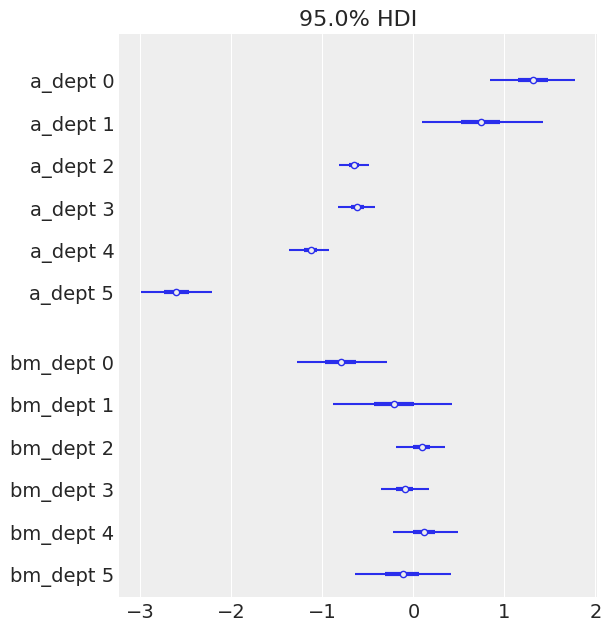

In [171]:
az.plot_forest(
    m14_3a, var_names=["a_dept", "bm_dept"], combined=True, hdi_prob=0.95
)

array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

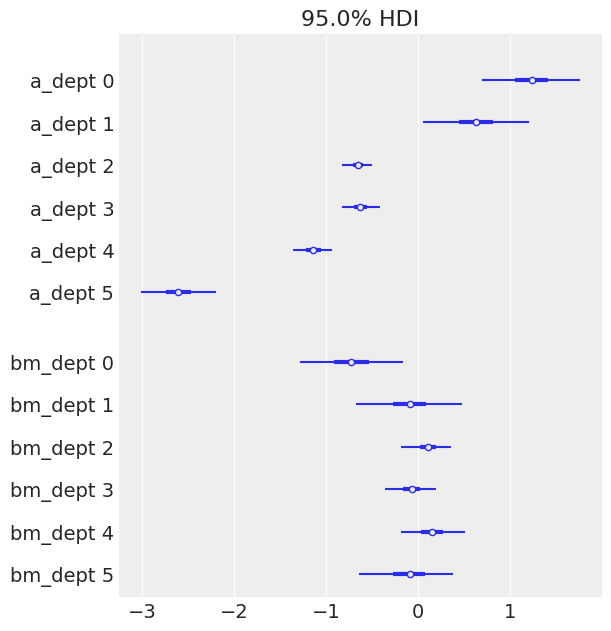

In [172]:
az.plot_forest(
    m14_3b, var_names=["a_dept", "bm_dept"], combined=True, hdi_prob=0.95
)

In [173]:
post_c = m14_3a.get_samples(group_by_chain=True)
neff_c = jnp.concatenate(
    [effective_sample_size(post_c[k].copy()).reshape(-1)
    for k in ["a_dept", "bm_dept"]]
)

post_nc = m14_3b.get_samples(group_by_chain=True)
neff_nc = jnp.concatenate(
    [effective_sample_size(post_nc[k].copy()).reshape(-1)
    for k in ["a_dept", "bm_dept"]]
)

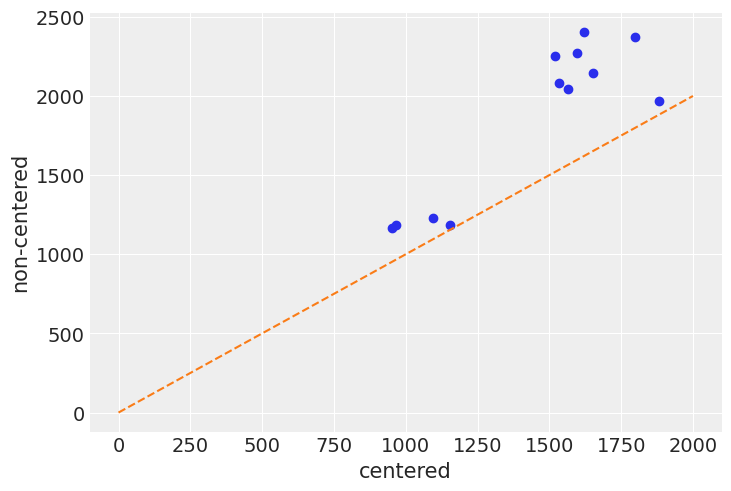

In [174]:
plt.plot(neff_c, neff_nc, 'o')
x = jnp.linspace(0, 2000, 100)
plt.gca().set(xlabel="centered", ylabel="non-centered")
plt.plot(x, x, "--")

---